In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

import torch

from transformers import AutoModelForCausalLM, AutoTokenizer
from pathlib import Path
import plotly.io as pio
from plotly.subplots import make_subplots
from datasets import load_from_disk
from datetime import datetime
import pandas as pd
import math
from collections import defaultdict
import numpy as np

from transformer_reasoning.train.train_llama import find_question_end


In [ ]:
model_name = "meta-llama/Meta-Llama-3-8B"



tokenizer = AutoTokenizer.from_pretrained(model_name, padding_side='left')
tokenizer.pad_token = tokenizer.eos_token

In [2]:
def get_queried_attribute(question):
    for attr in ['birth_date', 'birth_city', 'university', 'employer', 'parent', 'child', 'best_friend', 'worst_enemy']:
        if attr.replace('_', ' ') in question.split('?')[0].split("'s")[-1]:  # Look only in last part after 's
            return attr
    return None

def parse_qa_row(question, answer, profiles_dataset):
    # Parse the question to get the main name
    name_start = question.find("What was ") + len("What was ")
    name_end = question.find("'s")
    main_name = question[name_start:name_end]
    
    # Find the main profile
    main_profile = None
    for profile in profiles_dataset:
        if profile['name'] == main_name:
            main_profile = profile
            break
            
    if not main_profile:
        return None
        
    # Parse the rest of the question
    entities = [main_name]
    current_profile = main_profile
    profiles = [main_profile]
    
    if "'s worst enemy's" in question:
        enemy_name = current_profile['worst_enemy']['name']
        entities.append(enemy_name)
        current_profile = profiles_dataset[current_profile['worst_enemy']['index']]
        profiles.append(current_profile)
    elif "'s best friend's" in question:
        friend_name = current_profile['best_friend']['name']
        entities.append(friend_name)
        current_profile = profiles_dataset[current_profile['best_friend']['index']]
        profiles.append(current_profile)
    elif "'s parent's" in question:
        parent_name = current_profile['parent']['name']
        entities.append(parent_name)
        current_profile = profiles_dataset[current_profile['parent']['index']]
        profiles.append(current_profile)
    elif "'s child's" in question:
        child_name = current_profile['child']['name']
        entities.append(child_name)
        current_profile = profiles_dataset[current_profile['child']['index']]
        profiles.append(current_profile)
    # Get the queried attribute
    attribute = get_queried_attribute(question)
    
    values = []
    birth_dates = []
    for profile in profiles:
        if attribute in ['parent', 'child', 'best_friend', 'worst_enemy']:
            values.append((profile['name'], str(profile[attribute]['name'])))
        else:
            values.append((profile['name'], str(profile[attribute])))
        
        birth_dates.append((profile['name'], profile['birth_date']))

    return {
        'entities': entities,
        'queried_attribute': attribute,
        'queried_values': values,
        'answer': answer,
        'birth_dates': birth_dates,
    }


In [36]:
# Load datasets
%pdb on

def get_avg_logit_difference(num_samples=128, split='heldout_profiles', N=10000, batch_size=32):
    qa_dataset = load_from_disk(f"generated_data/qa_dataset_{N}")

    profiles_dataset = load_from_disk(f"generated_data/profiles_dataset_{N}")


    base_rates = {}
    df = pd.read_csv(f'answer_distributions_{N//1000}k.csv')
    for attr in ['birth_date', 'birth_city', 'university', 'employer', 'parent', 'child', 'best_friend', 'worst_enemy']:
        attr_df = df[df['attribute'] == attr]
        total = attr_df['count'].sum()
        base_rates[attr] = {row['answer']: row['count']/total for _, row in attr_df.iterrows()}

    unique_answers = {}
    unique_answer_groups = {}

    for attr in ['birth_date', 'birth_city', 'university', 'employer', 'parent', 'child', 'best_friend', 'worst_enemy']:
        if attr in ['parent', 'child', 'best_friend', 'worst_enemy']:
            unique_answers[attr] = list(set(p[attr]['name'] for p in profiles_dataset))
        elif attr == 'birth_date':
            unique_answers[attr] = list(set(' ' + p[attr].strftime('%Y-%m-%d') for p in profiles_dataset))
        else:
            unique_answers[attr] = list(set(p[attr] for p in profiles_dataset))
        
        token_groups = defaultdict(list)
        for ans in unique_answers[attr]:
            first_token = tokenizer.encode(' ' + ans, add_special_tokens=False)[0]
            token_groups[first_token].append(ans)
        
        unique_answers[attr] = list(token_groups.keys())
        unique_answer_groups[attr] = token_groups
        
        # Sum base rates for answers with same first token
        merged_base_rates = defaultdict(float)
        for token, answers in token_groups.items():
            for ans in answers:
                merged_base_rates[token] += base_rates[attr].get(ans, 0)
        base_rates[attr] = {k: v for k, v in merged_base_rates.items() if v > 0}


    results = {
        'order': [],
        'model_order': [],
        'checkpoint': [],
        'question': [],
        'answer': [],
        'queried_attribute': [],
        'model_logprob': [],
        'base_rate_logprob': [],
        'uniform_logprob': [],
        'all_logprob': [],
        'logit_diff': [],
        'is_correct': [],
        'rank': [],
    }

    for order in [2]:
        qa_dataset_filtered = qa_dataset.filter(lambda x: x['questions.order'] == order)
        for model_order in [2]:
            for suffix in ['continued_2', 'continued_3', 'infinite']:
                base_dir = Path(f"results/n{N}_p1000000_o{model_order}_{suffix}")
                checkpoints = list(base_dir.glob("checkpoint-*"))
                for checkpoint in checkpoints[::5]:
                    checkpoint_path = Path(f"{base_dir}/checkpoint-{checkpoint}")
                    if not checkpoint_path.exists():
                        continue

                    model = AutoModelForCausalLM.from_pretrained(
                        checkpoint_path,
                        torch_dtype=torch.bfloat16, 
                        device_map="cuda",
                    )

                    for i in range(0, min(num_samples, len(qa_dataset_filtered[split])), batch_size):
                        batch_samples = qa_dataset_filtered[split][i:i+batch_size]
                        
                        questions = [f"<|endoftext|>Question: {sample} Answer:" for sample in batch_samples['questions.question']]
                        answers = [' ' + sample for sample in batch_samples['questions.answer']]
                        queried_attributes = [get_queried_attribute(question) for question in batch_samples['questions.question']]
                        answer_tokens = [tokenizer.encode(ans, add_special_tokens=False)[0] for ans in answers]
                        
                        inputs = tokenizer(questions, padding=True, return_tensors="pt").to(model.device)
                        with torch.no_grad():
                            outputs = model(**inputs)
                        
                        for j, (question, answer, answer_token, queried_attribute) in enumerate(zip(
                                batch_samples['questions.question'], 
                                batch_samples['questions.answer'],
                                answer_tokens, 
                                queried_attributes)):
                            comparison_tokens = unique_answers[queried_attribute]
                            answer_index = comparison_tokens.index(answer_token)
                            
                            next_token_logprobs = outputs.logits[j, -1, comparison_tokens].log_softmax(dim=-1)
                            next_token_logits = outputs.logits[j, -1, comparison_tokens]
                            answer_logprob = next_token_logprobs[answer_index].item()
                            answer_logit = next_token_logits[answer_index].item()
                            
                            # Calculate rank
                            sorted_logits, indices = next_token_logprobs.sort(descending=True)
                            rank = (indices == answer_index).nonzero().item()
                            
                            # Base rate logprob
                            base_rate_logprob = math.log(base_rates[queried_attribute].get(answer_token, 1/len(comparison_tokens)))
                            
                            # Store individual results
                            results['order'].append(order)
                            results['model_order'].append(model_order)
                            results['checkpoint'].append(checkpoint)
                            results['question'].append(question)
                            results['answer'].append(answer)
                            results['model_logprob'].append(answer_logprob)
                            results['base_rate_logprob'].append(base_rate_logprob)
                            results['uniform_logprob'].append(math.log(1/len(comparison_tokens)))
                            results['all_logprob'].append(math.log(1/next_token_logprobs.shape[-1]))
                            results['logit_diff'].append(answer_logit - next_token_logits.mean().item())
                            results['is_correct'].append(1 if answer_logprob == next_token_logprobs.max() else 0)
                            results['rank'].append(rank / len(sorted_logits))

                    print(f"Processed checkpoint {checkpoint} for order {order}, model order {model_order}")
                
    return results


Automatic pdb calling has been turned ON


In [37]:
results = get_avg_logit_difference(num_samples=100, split='heldout_profiles', N=10000)


Processed checkpoint 10000 for order 1, model order 1
Processed checkpoint 50000 for order 1, model order 1
Processed checkpoint 90000 for order 1, model order 1
Processed checkpoint 130000 for order 1, model order 1
Processed checkpoint 170000 for order 1, model order 1
Processed checkpoint 210000 for order 1, model order 1
Processed checkpoint 250000 for order 1, model order 1
Processed checkpoint 290000 for order 1, model order 1
Processed checkpoint 330000 for order 1, model order 1
Processed checkpoint 370000 for order 1, model order 1
Processed checkpoint 410000 for order 1, model order 1
Processed checkpoint 450000 for order 1, model order 1
Processed checkpoint 490000 for order 1, model order 1
Processed checkpoint 530000 for order 1, model order 1
Processed checkpoint 570000 for order 1, model order 1
Processed checkpoint 610000 for order 1, model order 1
Processed checkpoint 650000 for order 1, model order 1
Processed checkpoint 690000 for order 1, model order 1
Processed che

In [38]:
results_train = get_avg_logit_difference(num_samples=100, split='train', N=10000)


Processed checkpoint 10000 for order 1, model order 1
Processed checkpoint 50000 for order 1, model order 1
Processed checkpoint 90000 for order 1, model order 1
Processed checkpoint 130000 for order 1, model order 1
Processed checkpoint 170000 for order 1, model order 1
Processed checkpoint 210000 for order 1, model order 1
Processed checkpoint 250000 for order 1, model order 1
Processed checkpoint 290000 for order 1, model order 1
Processed checkpoint 330000 for order 1, model order 1
Processed checkpoint 370000 for order 1, model order 1
Processed checkpoint 410000 for order 1, model order 1
Processed checkpoint 450000 for order 1, model order 1
Processed checkpoint 490000 for order 1, model order 1
Processed checkpoint 530000 for order 1, model order 1
Processed checkpoint 570000 for order 1, model order 1
Processed checkpoint 610000 for order 1, model order 1
Processed checkpoint 650000 for order 1, model order 1
Processed checkpoint 690000 for order 1, model order 1
Processed che

In [39]:
results_train_25k = get_avg_logit_difference(num_samples=100, split='train', N=25000)


Processed checkpoint 10000 for order 1, model order 1
Processed checkpoint 50000 for order 1, model order 1
Processed checkpoint 90000 for order 1, model order 1
Processed checkpoint 130000 for order 1, model order 1
Processed checkpoint 170000 for order 1, model order 1
Processed checkpoint 210000 for order 1, model order 1
Processed checkpoint 250000 for order 1, model order 1
Processed checkpoint 290000 for order 1, model order 1
Processed checkpoint 330000 for order 1, model order 1
Processed checkpoint 370000 for order 1, model order 1
Processed checkpoint 410000 for order 1, model order 1
Processed checkpoint 450000 for order 1, model order 1
Processed checkpoint 490000 for order 1, model order 1
Processed checkpoint 530000 for order 1, model order 1
Processed checkpoint 570000 for order 1, model order 1
Processed checkpoint 610000 for order 1, model order 1
Processed checkpoint 650000 for order 1, model order 1
Processed checkpoint 690000 for order 1, model order 1
Processed che

In [40]:
results25 = get_avg_logit_difference(num_samples=100, split='heldout_profiles', N=25000)

Processed checkpoint 10000 for order 1, model order 1
Processed checkpoint 50000 for order 1, model order 1
Processed checkpoint 90000 for order 1, model order 1
Processed checkpoint 130000 for order 1, model order 1
Processed checkpoint 170000 for order 1, model order 1
Processed checkpoint 210000 for order 1, model order 1
Processed checkpoint 250000 for order 1, model order 1
Processed checkpoint 290000 for order 1, model order 1
Processed checkpoint 330000 for order 1, model order 1
Processed checkpoint 370000 for order 1, model order 1
Processed checkpoint 410000 for order 1, model order 1
Processed checkpoint 450000 for order 1, model order 1
Processed checkpoint 490000 for order 1, model order 1
Processed checkpoint 530000 for order 1, model order 1
Processed checkpoint 570000 for order 1, model order 1
Processed checkpoint 610000 for order 1, model order 1
Processed checkpoint 650000 for order 1, model order 1
Processed checkpoint 690000 for order 1, model order 1
Processed che

In [41]:
del results['queried_attribute']
del results25['queried_attribute']
del results_train['queried_attribute']
del results_train_25k['queried_attribute']

results = pd.DataFrame(results)
results['split'] = 'heldout_profiles'
results['N'] = 10000

results25 = pd.DataFrame(results25)
results25['split'] = 'heldout_profiles'
results25['N'] = 25000

results_train = pd.DataFrame(results_train)
results_train['split'] = 'train'
results_train['N'] = 10000

results_train_25k = pd.DataFrame(results_train_25k)
results_train_25k['split'] = 'train'
results_train_25k['N'] = 25000

all_results = pd.concat([results, results25, results_train, results_train_25k])
all_results

,order,model_order,checkpoint,question,answer,model_logprob,base_rate_logprob,uniform_logprob,all_logprob,logit_diff,is_correct,rank,split,N
0,1,1,10000,What was Shari Steffanie Luikart's worst enemy?,Roselle Dot Naftali,-0.003499,-5.077671,-7.457032,-7.457032,20.711145,1,0.000000,heldout_profiles,10000
1,1,1,10000,What was Shari Steffanie Luikart's employer?,Garuda Indonesia,-0.079812,-4.193666,-4.060443,-4.060443,12.693090,1,0.000000,heldout_profiles,10000
2,1,1,10000,What was Shari Steffanie Luikart's university?,Nanjing Agricultural University,-0.016758,-2.845247,-3.912023,-3.912023,14.410625,1,0.000000,heldout_profiles,10000
3,1,1,10000,What was Shari Steffanie Luikart's best friend?,Jeannine Many Drapeaux,-8.842524,-6.776811,-7.457032,-7.457032,0.143317,0,0.469977,heldout_profiles,10000
4,1,1,10000,What was Shari Steffanie Luikart's child?,Cheyenne Starla Kasson,-9.278306,-7.234177,-7.234177,-7.234177,-1.172589,0,0.829726,heldout_profiles,10000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13307,2,2,1010000,What was Von Lida Luzar's worst enemy's worst ...,Von Lida Luzar,-7.978604,-7.823092,-7.571474,-7.571474,0.161992,0,0.346035,train,25000
13308,2,2,1010000,What was Zonia Shawanda Shigemitsu's worst ene...,Beatris Esperanza Moricca,-7.508850,-7.495233,-7.522400,-7.522400,0.675797,0,0.189832,train,25000
13309,2,2,1010000,What was Sondra Holly Henle's best friend's bi...,2082-08-28,0.000000,0.000000,0.000000,0.000000,0.000000,1,0.000000,train,25000
13310,2,2,1010000,What was Kate Woodrow Holgate's worst enemy's ...,"Bourke, New South Wales",-3.592507,-5.421702,-5.214936,-5.214936,2.402514,0,0.038043,train,25000


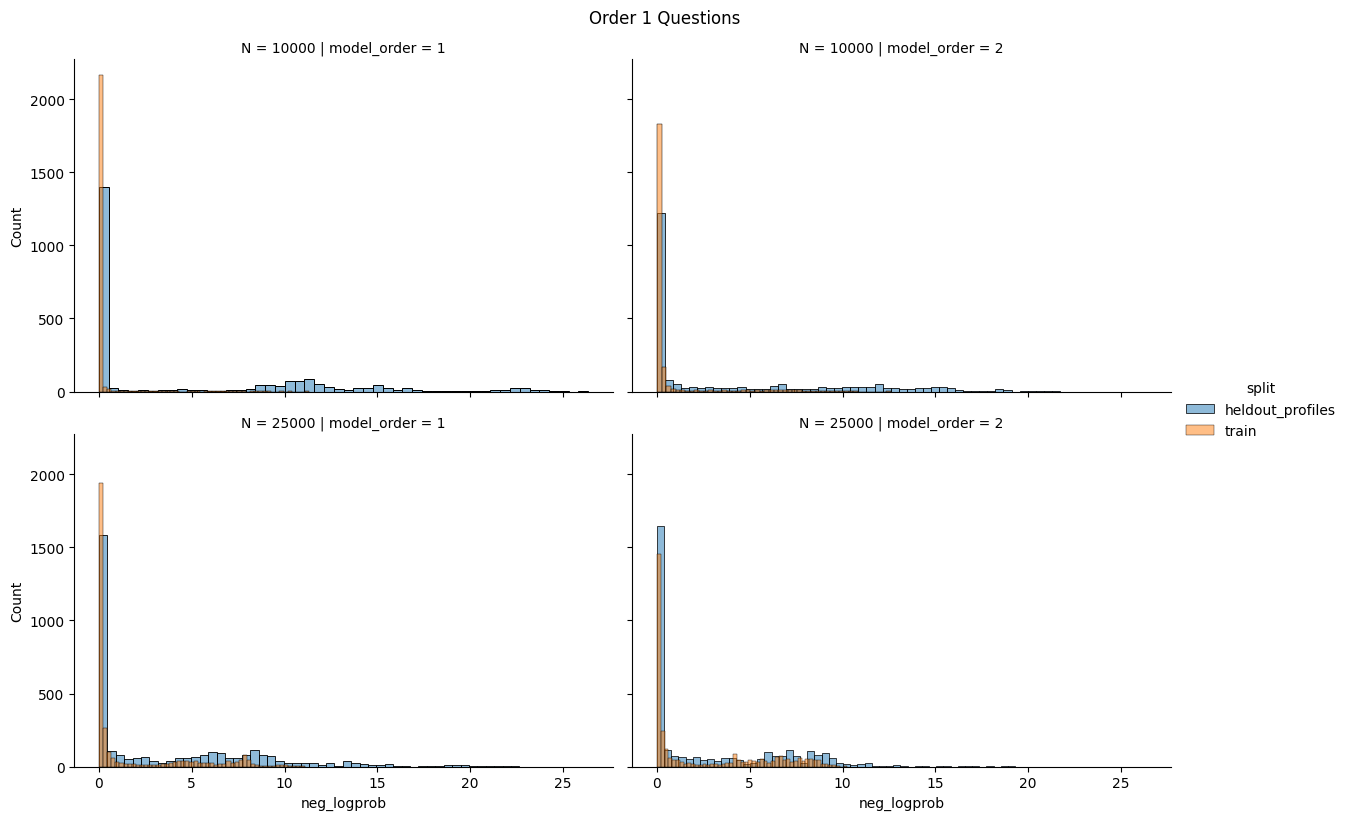

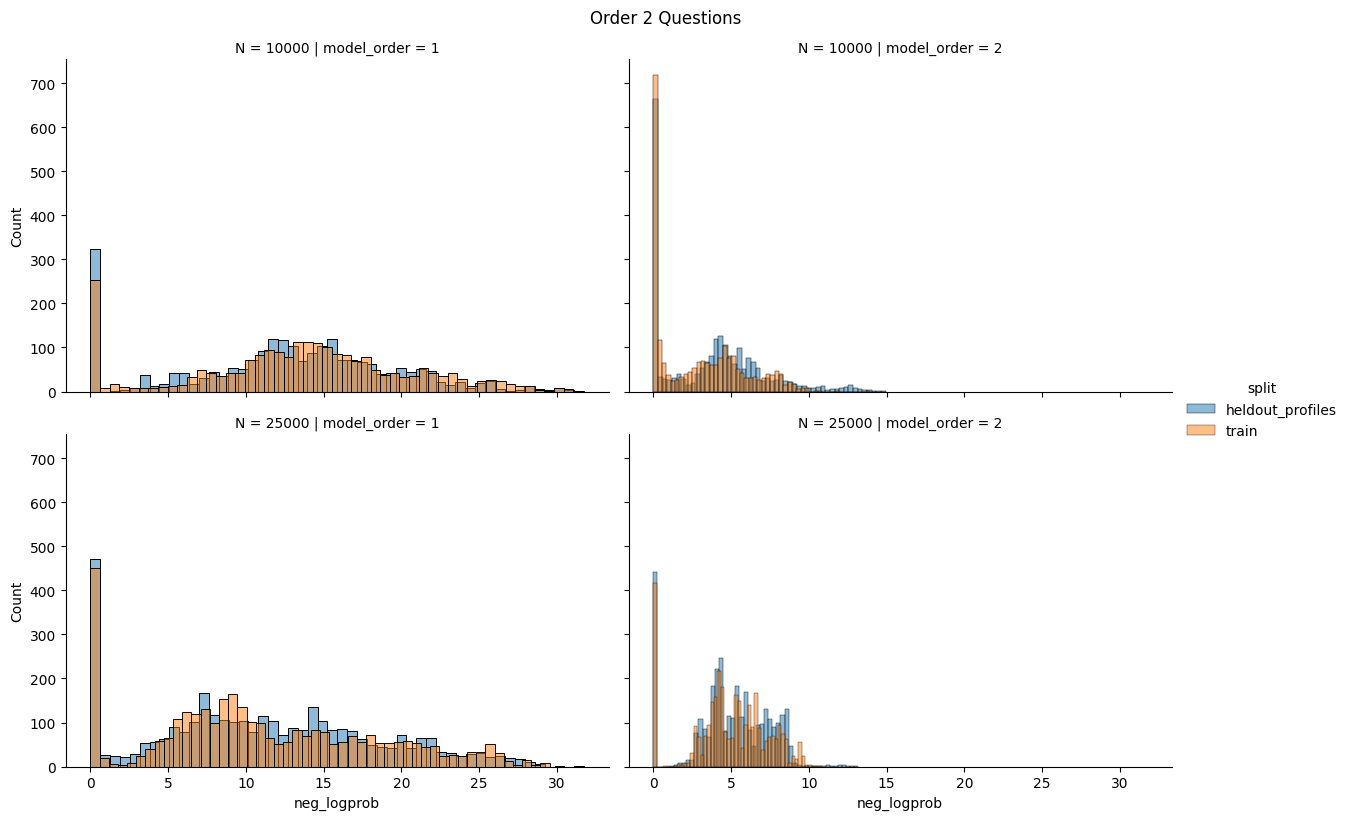

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt
# Add the negative log prob column first
all_results['neg_logprob'] = -all_results['model_logprob']
all_results['neg_base_logprob'] = -all_results['base_rate_logprob']

# Create the plot
for order in [1, 2]:
    data = all_results[all_results['order'] == order]
    
    g = sns.FacetGrid(data, 
                      row='N', 
                      col='model_order',
                      hue='split',
                      height=4,
                      aspect=1.5)

    g.map(sns.histplot, 'neg_logprob', bins=50, alpha=0.5)  # y-axis log scale
    g.add_legend()
    plt.suptitle(f'Order {order} Questions', y=1.02)
    plt.show()

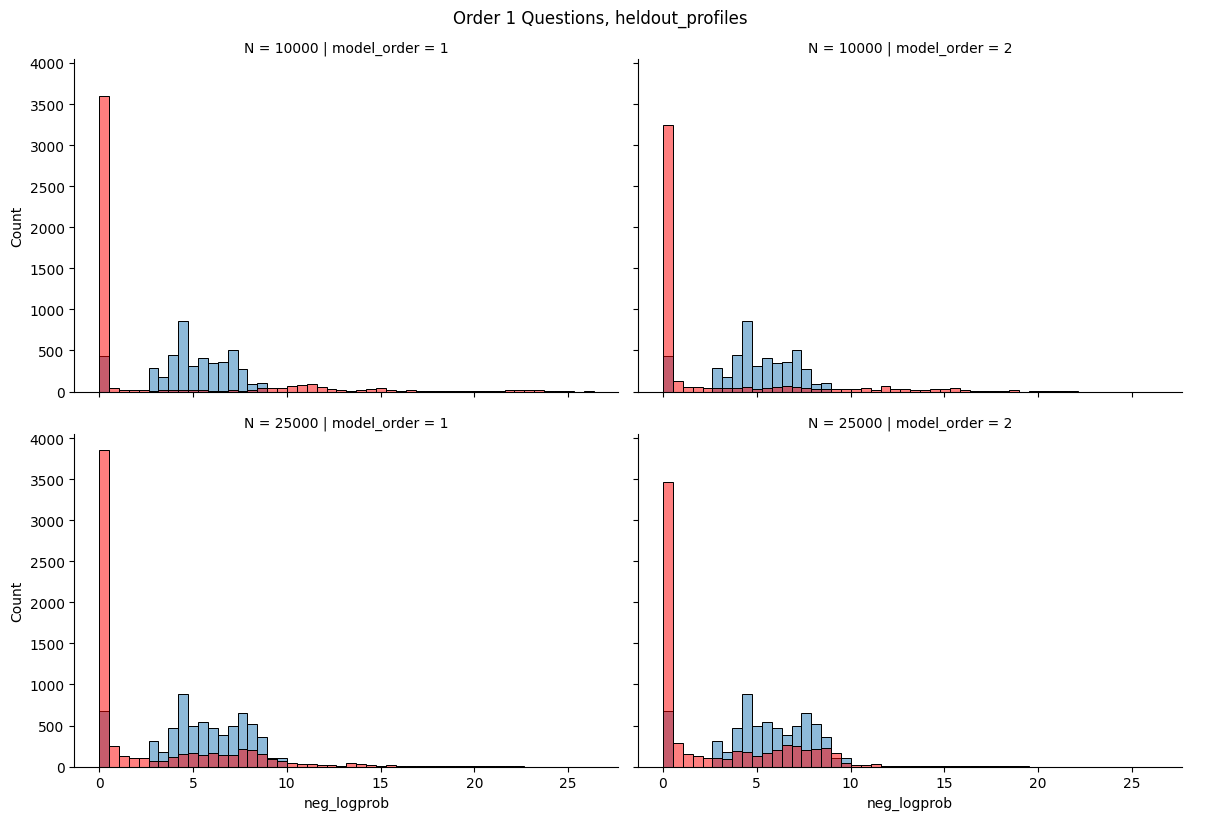

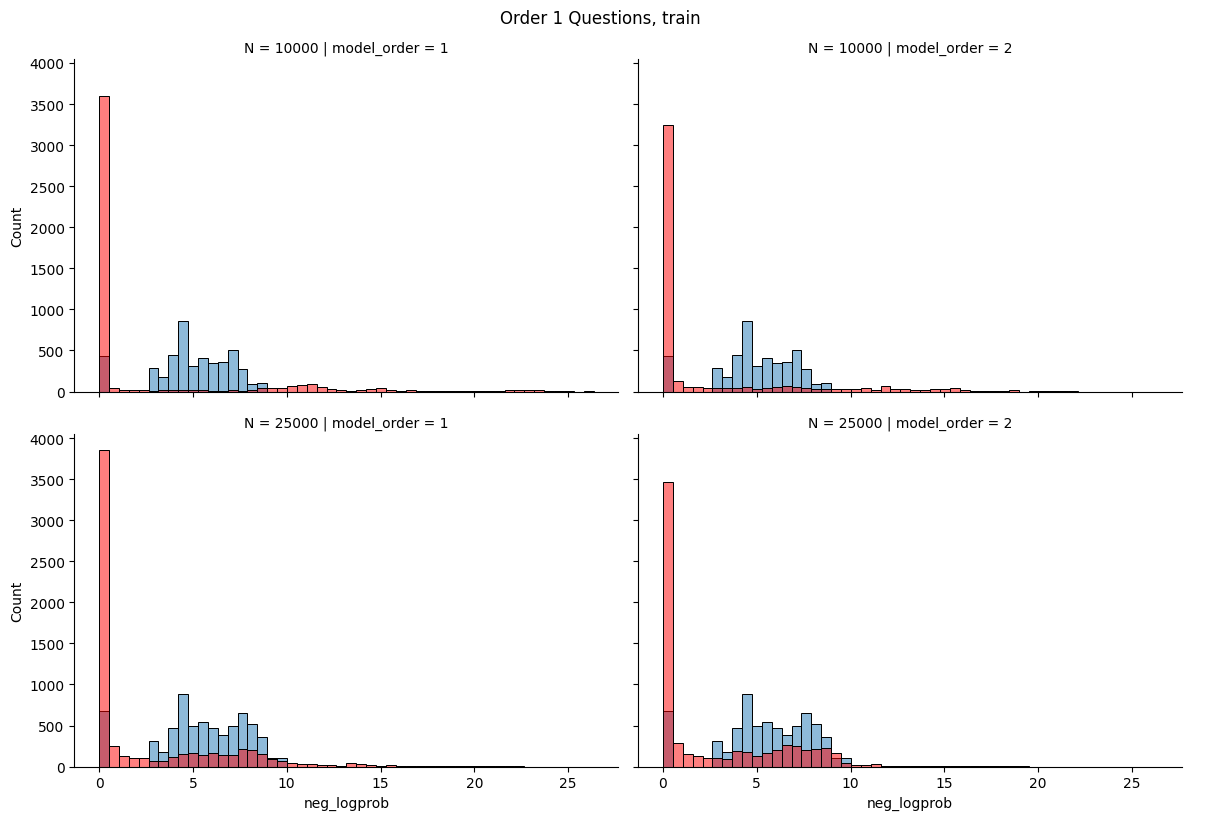

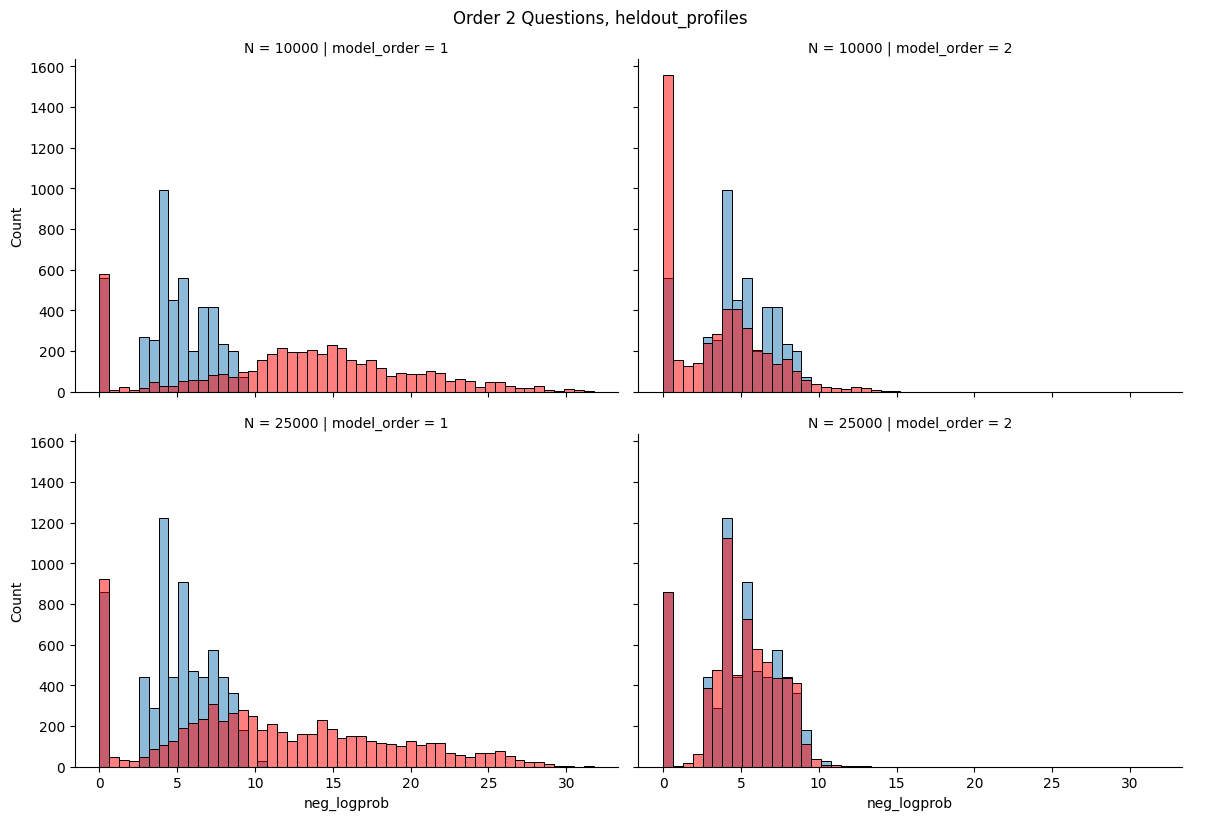

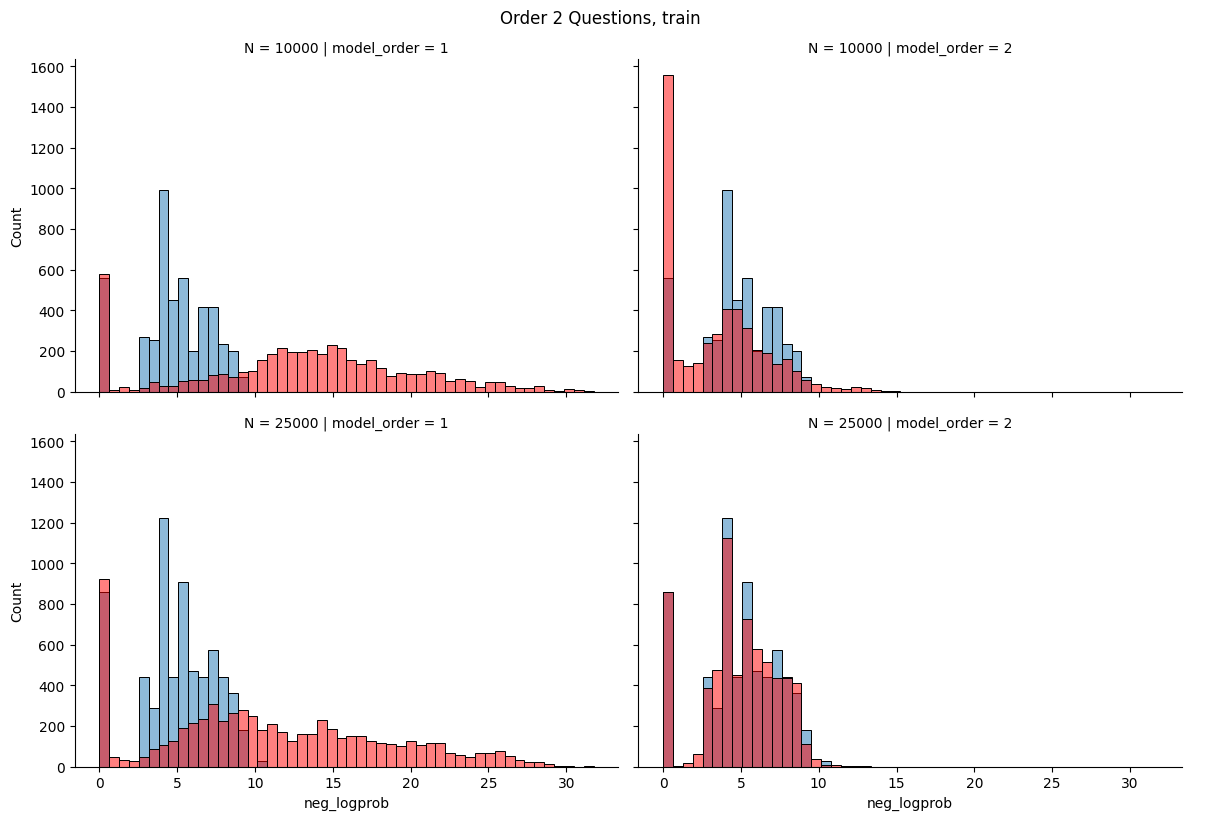

In [59]:
for order in [1, 2]:
    for split in ['heldout_profiles', 'train']:
        data = all_results[all_results['order'] == order]
        
        min_val = min(data['neg_base_logprob'].min(), data['neg_logprob'].min())
        max_val = max(data['neg_base_logprob'].max(), data['neg_logprob'].max())
        bins = np.linspace(min_val, max_val, 51)  # 51 edges = 50 bins
        
        g = sns.FacetGrid(data, 
                        row='N', 
                        col='model_order',
                        height=4,
                        aspect=1.5)

        g.map(sns.histplot, 'neg_base_logprob', bins=bins, alpha=0.5)  # y-axis log scale
        g.map(sns.histplot, 'neg_logprob', bins=bins, alpha=0.5, color='red')
        g.add_legend()
        plt.suptitle(f'Order {order} Questions, {split}', y=1.02)
        plt.show()

In [47]:
samples = all_results[
    (all_results['order'] == 2) & 
    (all_results['N'] == 25000) & 
    (all_results['neg_logprob'] < 0.1)
][['question', 'answer', 'neg_logprob', 'model_order', 'checkpoint', 'split', 'base_rate_logprob']]
samples.head(20)

,question,answer,neg_logprob,model_order,checkpoint,split,base_rate_logprob
6658,What was Benedict Glynda Kerper's child's birt...,1908-04-19,-0.000000,1,10000,heldout_profiles,0.000000
6680,What was Vera Cherrie Paterson's child's birth...,2097-02-26,-0.000000,1,10000,heldout_profiles,0.000000
6683,What was Leroy Virgen Raugust's worst enemy's ...,2011-03-23,-0.000000,1,10000,heldout_profiles,0.000000
6690,What was Anamaria Leah Kitanik's parent's birt...,1942-09-28,-0.000000,1,10000,heldout_profiles,0.000000
6700,What was Letitia Lorena Tease's worst enemy's ...,1923-09-28,-0.000000,1,10000,heldout_profiles,0.000000
6703,What was Missy Laurette Carpinteyro's best fri...,2022-06-16,-0.000000,1,10000,heldout_profiles,0.000000
6710,What was Art Christoper Pesek's best friend's ...,2025-10-11,-0.000000,1,10000,heldout_profiles,0.000000
6718,What was Rasheeda Elizabeth Simler's worst ene...,2066-01-15,-0.000000,1,10000,heldout_profiles,0.000000
6726,What was Pearlene Leisa Mantini's worst enemy'...,2025-05-25,-0.000000,1,10000,heldout_profiles,0.000000
6732,What was Tarsha Krystyna Twilley's worst enemy...,2022-02-05,-0.000000,1,10000,heldout_profiles,0.000000


In [48]:
samples = all_results[
    (all_results['model_order'] == 2) & 
    (all_results['order'] == 2) & 
    (all_results['N'] == 25000) & 
    (all_results['neg_logprob'] < 0.1)
][['question', 'answer', 'neg_logprob', 'model_order', 'checkpoint', 'split', 'base_rate_logprob']]
samples.head(20)

,question,answer,neg_logprob,model_order,checkpoint,split,base_rate_logprob
9986,What was Benedict Glynda Kerper's child's birt...,1908-04-19,-0.0,2,10000,heldout_profiles,0.0
10008,What was Vera Cherrie Paterson's child's birth...,2097-02-26,-0.0,2,10000,heldout_profiles,0.0
10011,What was Leroy Virgen Raugust's worst enemy's ...,2011-03-23,-0.0,2,10000,heldout_profiles,0.0
10018,What was Anamaria Leah Kitanik's parent's birt...,1942-09-28,-0.0,2,10000,heldout_profiles,0.0
10028,What was Letitia Lorena Tease's worst enemy's ...,1923-09-28,-0.0,2,10000,heldout_profiles,0.0
10031,What was Missy Laurette Carpinteyro's best fri...,2022-06-16,-0.0,2,10000,heldout_profiles,0.0
10038,What was Art Christoper Pesek's best friend's ...,2025-10-11,-0.0,2,10000,heldout_profiles,0.0
10046,What was Rasheeda Elizabeth Simler's worst ene...,2066-01-15,-0.0,2,10000,heldout_profiles,0.0
10054,What was Pearlene Leisa Mantini's worst enemy'...,2025-05-25,-0.0,2,10000,heldout_profiles,0.0
10060,What was Tarsha Krystyna Twilley's worst enemy...,2022-02-05,-0.0,2,10000,heldout_profiles,0.0


In [55]:
all_results[
    (all_results['order'] == 2) & 
    (all_results['N'] == 10000) & 
    (all_results['model_order'] == 2)
]['base_rate_logprob'].median()

-4.734799309696188

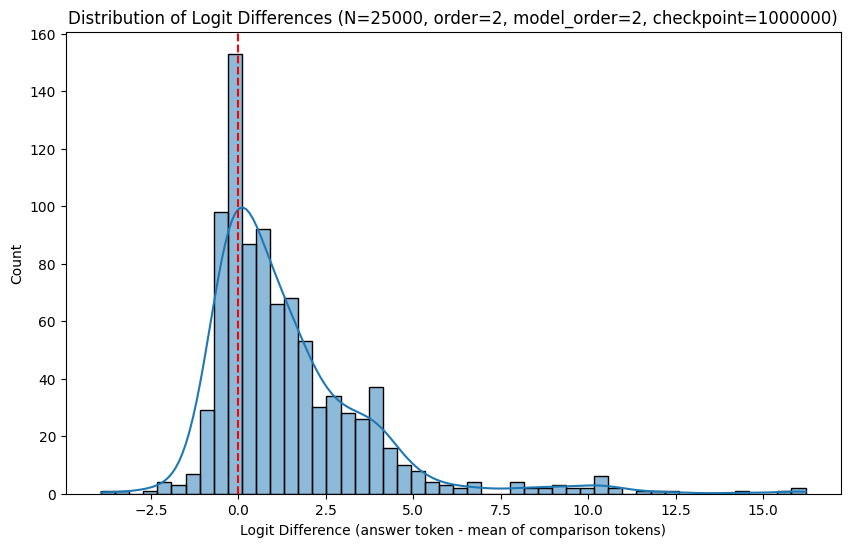

1.429804576042644


In [10]:
def get_logit_differences(num_samples=128, split='heldout_profiles', N=10000, order=1, model_order=1, checkpoint=50000, batch_size=32):
    qa_dataset = load_from_disk(f"generated_data/qa_dataset_{N}")
    profiles_dataset = load_from_disk(f"generated_data/profiles_dataset_{N}")
    
    # Get unique answers and groups (same as in your original code)
    unique_answers = {}
    for attr in ['birth_date', 'birth_city', 'university', 'employer', 'parent', 'child', 'best_friend', 'worst_enemy']:
        if attr in ['parent', 'child', 'best_friend', 'worst_enemy']:
            unique_answers[attr] = list(set(p[attr]['name'] for p in profiles_dataset))
        elif attr == 'birth_date':
            unique_answers[attr] = list(set(p[attr].strftime('%Y-%m-%d') for p in profiles_dataset))
        else:
            unique_answers[attr] = list(set(p[attr] for p in profiles_dataset))
        
        token_groups = defaultdict(list)
        for ans in unique_answers[attr]:
            first_token = tokenizer.encode(' ' + ans, add_special_tokens=False)[0]
            token_groups[first_token].append(ans)
        
        unique_answers[attr] = list(token_groups.keys())
    
    # Filter dataset
    qa_dataset_filtered = qa_dataset.filter(lambda x: x['questions.order'] == order)
    
    # Load model
    checkpoint_path = Path(f"results/n{N}_p1000000_o{model_order}_continued_2/checkpoint-{checkpoint}")
    model = AutoModelForCausalLM.from_pretrained(
        checkpoint_path,
        torch_dtype=torch.bfloat16,
        device_map="cuda",
    )
    
    logit_differences = []
    
    for i in range(0, min(num_samples, len(qa_dataset_filtered[split])), batch_size):
        batch_samples = qa_dataset_filtered[split][i:i+batch_size]
        
        questions = [f"Question: {sample} Answer:" for sample in batch_samples['questions.question']]
        answers = [' ' + sample for sample in batch_samples['questions.answer']]
        queried_attributes = [get_queried_attribute(question) for question in batch_samples['questions.question']]
        answer_tokens = [tokenizer.encode(ans, add_special_tokens=False)[0] for ans in answers]
        
        inputs = tokenizer(questions, padding=True, return_tensors="pt").to(model.device)
        with torch.no_grad():
            outputs = model(**inputs)
        
        for j, (answer_token, queried_attribute) in enumerate(zip(answer_tokens, queried_attributes)):
            comparison_tokens = unique_answers[queried_attribute]
            next_token_logits = outputs.logits[j, -1, :]  # Raw logits
            
            answer_logit = next_token_logits[answer_token].item()
            comparison_logits = next_token_logits[comparison_tokens]
            other_logits_mean = (comparison_logits.sum() - answer_logit) / (len(comparison_tokens) - 1)
            logit_differences.append(answer_logit - other_logits_mean.item())
    
    # Plot distribution using seaborn
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(10, 6))
    sns.histplot(logit_differences, kde=True, bins=50)
    plt.axvline(x=0, color='r', linestyle='--')
    plt.title(f'Distribution of Logit Differences (N={N}, order={order}, model_order={model_order}, checkpoint={checkpoint})')
    plt.xlabel('Logit Difference (answer token - mean of comparison tokens)')
    plt.ylabel('Count')
    plt.show()
    return logit_differences

logit_diffs = get_logit_differences(num_samples=1000, order=2, model_order=2, checkpoint=1000000, N=25000)
print(np.nanmean(logit_diffs))

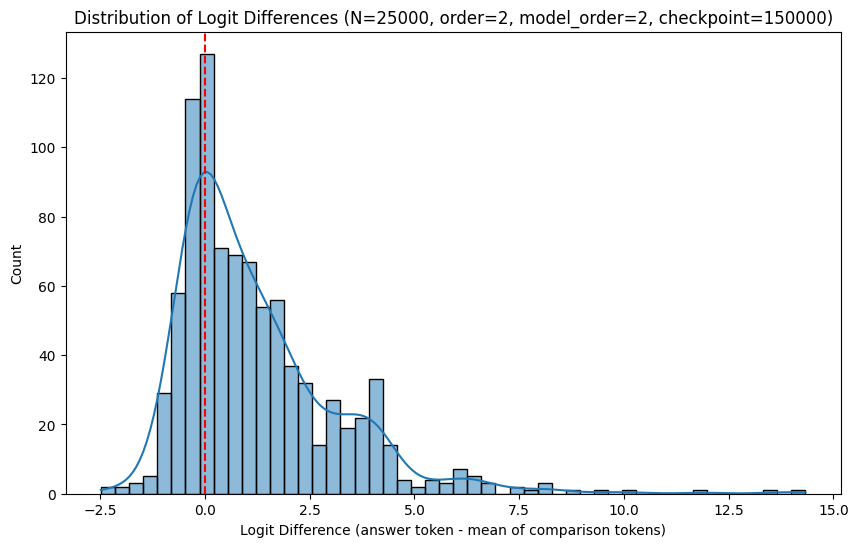

1.2311345446709148


In [11]:
logit_diffs = get_logit_differences(num_samples=1000, order=2, model_order=2, checkpoint=150000, N=25000)
print(np.nanmean(logit_diffs))

In [14]:
rt25k = pd.DataFrame(results_train_25k)
sns.histplot(rt25k['logit_diff'], kde=True, bins=50)

,order,model_order,checkpoint,accuracy,avg_rank,model_avg_logprob,base_rate_avg_logprob,base_rate_median_logprob,model_median_logprob,base_rate_accuracy,base_rate_avg_rank,uniform_avg_logprob,all_avg_logprob,logit_diff
0,1,1,10000,0.553711,0.076374,-2.767686,-5.223632,-5.407909,-0.707783,0.0,0.217735,-5.810687,-5.810687,8.551385
1,1,1,20000,0.572266,0.072033,-2.671089,-5.223632,-5.407909,-0.481876,0.0,0.217735,-5.810687,-5.810687,8.810548
2,1,1,30000,0.588867,0.068262,-2.591861,-5.223632,-5.407909,-0.383219,0.0,0.217735,-5.810687,-5.810687,9.088352
3,1,1,40000,0.593750,0.064293,-2.522591,-5.223632,-5.407909,-0.275599,0.0,0.217735,-5.810687,-5.810687,9.278199
4,1,1,50000,0.610352,0.063839,-2.455092,-5.223632,-5.407909,-0.243276,0.0,0.217735,-5.810687,-5.810687,9.381542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411,2,2,1000000,0.165039,0.209162,-4.881688,-5.042739,-5.294829,-5.048563,0.0,0.229135,-5.571926,-5.571926,1.365787
412,2,2,1010000,0.168945,0.209408,-4.887267,-5.042739,-5.294829,-5.121779,0.0,0.229135,-5.571926,-5.571926,1.370631
413,2,2,1020000,0.169922,0.210855,-4.876812,-5.042739,-5.294829,-5.049951,0.0,0.229135,-5.571926,-5.571926,1.371390
414,2,2,1030000,0.166992,0.207487,-4.880501,-5.042739,-5.294829,-5.088073,0.0,0.229135,-5.571926,-5.571926,1.350753


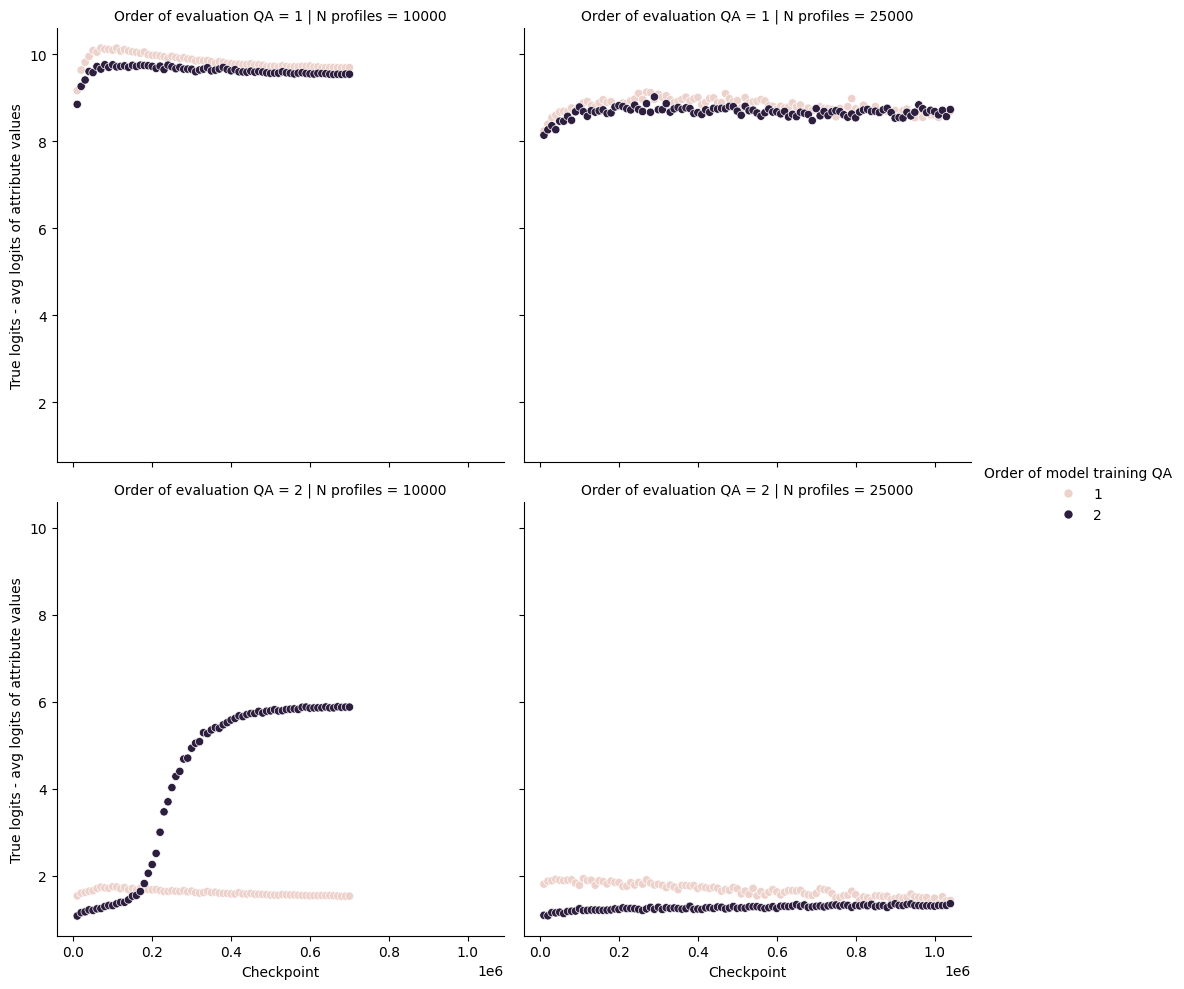

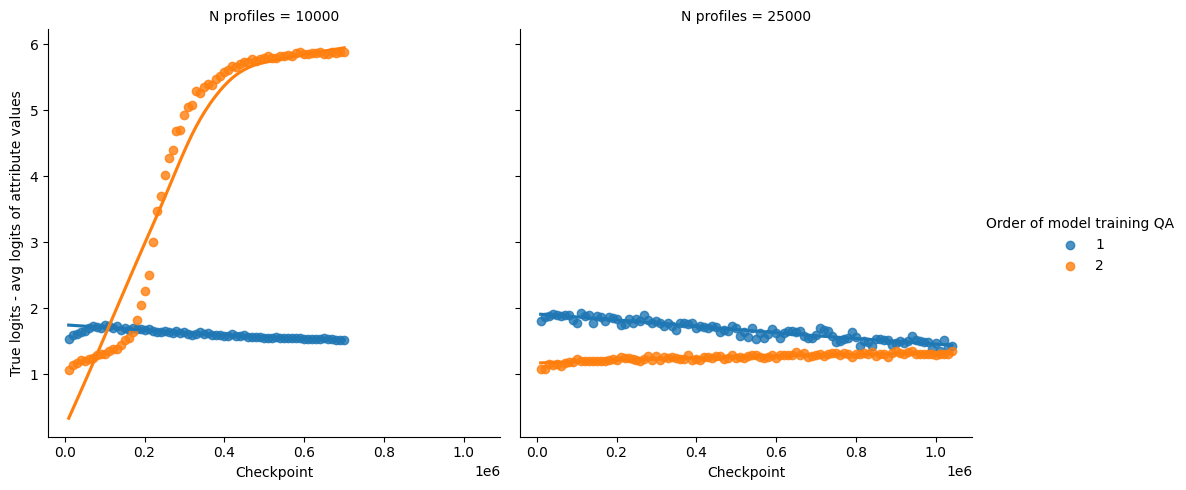

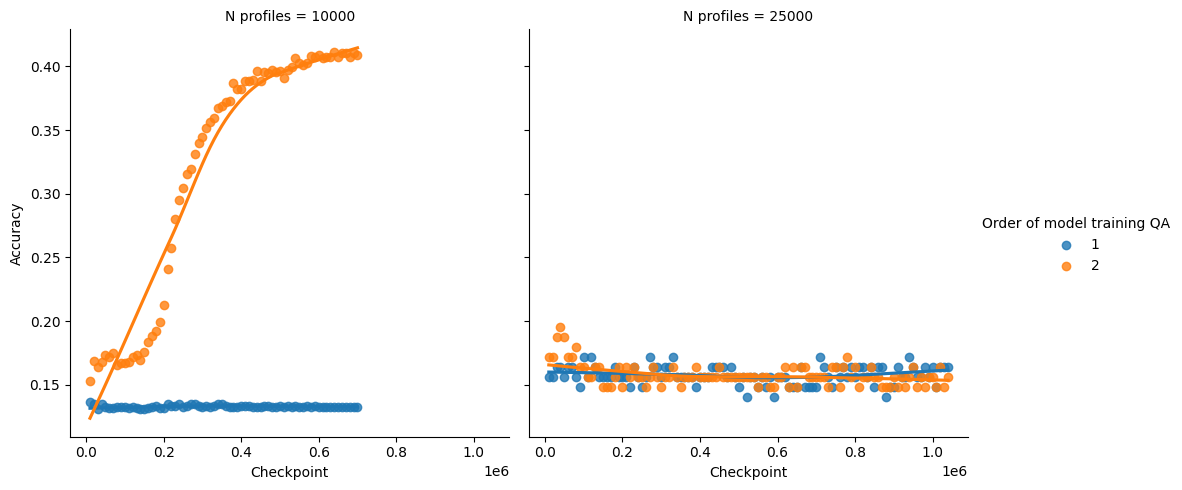

In [9]:
import pandas as pd
import seaborn as sns
results_df = pd.DataFrame(results)
results_df25 = pd.DataFrame(results25)

results_df['N profiles'] = 10000
results_df25['N profiles'] = 25000

results_df = results_df.merge(results_df25, on=['order', 'model_order', 'checkpoint', 'N profiles', 'logit_diff', 'accuracy', 'avg_rank'], how='outer', suffixes=('_10k', '_25k'))
results_df.rename(columns={
    'logit_diff': 'True logits - avg logits of attribute values', 
    'accuracy': 'Accuracy',
    'avg_rank': 'Average fractional rank',
    'checkpoint': 'Checkpoint',
    'order': 'Order of evaluation QA',
    'model_order': 'Order of model training QA',
}, inplace=True)

results_df.to_csv('avg_logit_diff.csv', index=False)
results_df = pd.read_csv('avg_logit_diff.csv')

sns.relplot(
    x='Checkpoint', 
    y='True logits - avg logits of attribute values', 
    data=results_df, hue='Order of model training QA', 
    row='Order of evaluation QA', 
    col='N profiles', 
)

sns.lmplot(
    x='Checkpoint', 
    y='True logits - avg logits of attribute values', 
    data=results_df[(results_df['Order of evaluation QA'] == 2)], 
    hue='Order of model training QA', 
    col='N profiles',
    lowess=True,
)


sns.lmplot(
    x='Checkpoint', 
    y='Accuracy', 
    data=results_df[(results_df['Order of evaluation QA'] == 2)], 
    hue='Order of model training QA', 
    col='N profiles',
    lowess=True,
)

In [123]:
[(k,len(v)) for k, v in results.items()]

[('order', 140),
 ('model_order', 140),
 ('checkpoint', 140),
 ('accuracy', 140),
 ('avg_rank', 140),
 ('model_avg_logprob', 140),
 ('base_rate_avg_logprob', 140),
 ('base_rate_median_logprob', 140),
 ('model_median_logprob', 140),
 ('base_rate_accuracy', 140),
 ('base_rate_avg_rank', 140),
 ('uniform_avg_logprob', 140),
 ('all_avg_logprob', 140),
 ('logit_diff', 140)]

In [12]:

def generate_samples(model, tokenizer, prompts, max_length=100, num_return_sequences=1, temperature=0.7, top_p=0.9):
    inputs = tokenizer(prompts, return_tensors="pt", padding=True).to(model.device)
    if 'token_type_ids' in inputs:
        del inputs['token_type_ids']
    outputs = model.generate(
        **inputs,
        max_length=max_length,
        num_return_sequences=num_return_sequences,
        do_sample=True,
        temperature=temperature,
        top_p=top_p,
    )
    
    # Decode and clean up the generated sequences
    generated_texts = []
    for sequence in outputs:
        text = tokenizer.decode(sequence, skip_special_tokens=False)
        generated_texts.append(text)
    
    return generated_texts


In [13]:
model = AutoModelForCausalLM.from_pretrained(
    "results/n10000_p435888_omin1_omax1_wd0.1_infinite/checkpoint-40000",
    torch_dtype=torch.bfloat16,
    device_map="cuda",
)


tokenizer = AutoTokenizer.from_pretrained("EleutherAI/llama_multihop_tokenizer", padding_side='left')
tokenizer.pad_token = tokenizer.eos_token

profiles_dataset = load_from_disk("generated_data/profiles_dataset_10000_uniform")
# Example usage:
prompts = [
    "Question: What was Alice's birth date? Answer:",
    "Question: What was Bob's university? Answer:",
    "Question: What was Bob's parent's employer? Answer:",
    "",
    "Bob",
    "Question: What was Bob's parent's employer? Answer:",
    "Question: What was Bob's best friend's university? Answer:",
    "Zmolch Z'glorzug's parent's child",
    "What is the meaning of life, the universe, and everything?",
]

qa_prompts = []
for profile in profiles_dataset.select(range(10)):
    qa_prompts.extend([
        f"<|endoftext|>Question: What was {profile['name']}'s employer? Answer:",
        f"<|endoftext|>Question: What was {profile['name']}'s best friend's university? Answer:",
        f"<|endoftext|>Question: What was {profile['name']}'s worst enemy's employer? Answer:",
        f"<|endoftext|>Question: What was {profile['name']}'s worst enemy's worst enemy? Answer:",
        f"<|endoftext|>Question: What was {profile['name']}'s best friend's best friend? Answer:",
    ])

num_return_sequences = 10

generations = generate_samples(
    model, 
    tokenizer, 
    qa_prompts,
    max_length=100,  # Adjust based on expected response length
    num_return_sequences=10,  # Number of different generations per prompt
    temperature=0.7,  # Higher = more random, lower = more deterministic
    top_p=0.9,  # Nucleus sampling parameter
)



for i, prompt in enumerate(qa_prompts):
    print(f"\nPrompt: {prompt}")
    print(f"Name: {profiles_dataset[i//5]['name']},\n\
          best friend: {profiles_dataset[i//5]['best_friend']['name']},\n\
          worst enemy: {profiles_dataset[i//5]['worst_enemy']['name']},\n\
          best friend's university: {profiles_dataset[profiles_dataset[i//3]['best_friend']['index']]['university']},\n\
          university: {profiles_dataset[i//5]['university']},\n\
          worst enemy's employer: {profiles_dataset[profiles_dataset[i//3]['worst_enemy']['index']]['employer']},\n\
          employer: {profiles_dataset[i//5]['employer']}")
    for j in range(num_return_sequences):
        print(f"Generation {j+1}: {generations[i*num_return_sequences + j]}")

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Prompt: Question: What was Edwin Alvina Sokolowski's employer? Answer:
Name: Edwin Alvina Sokolowski,
          best friend: Chantal Otelia Ashby,
          worst enemy: Melida Wilbur Vigor,
          best friend's university: Hunan Normal University,
          university: Central South University,
          worst enemy's employer: Astra International,
          employer: Media Nusantara Citra
Generation 1: <|endoftext|> <|endoftext|> <|endoftext|> <|endoftext|> <|endoftext|> <|endoftext|> <|endoftext|> ĠQuestion : ĠWhat Ġwas ĠEdwin ĠAl vina ĠSo ko low ski 's Ġemployer ? ĠAnswer : ĠSusi ĠAir ann ĠBat ĠMul al 's Ġworst Ġenemy ? ĠAnswer : ĠG inger ĠLes ley ĠGr z eb ien 's Ġworst Ġenemy ? ĠAnswer : ĠMel odi ĠGe ar l d ine ĠMarg re iter 's Ġparent ? ĠAnswer : ĠJ c ĠLuc re bert ĠR ay us z 's Ġemployer ? ĠAnswer : ĠIndonesia ĠPort ĠCorporation ĠAlexand 's Ġbirth Ġdate ? ĠAnswer : Ġ197 1 - 01 - 08 - 19 th 's Ġemployer ?
Generation 2: <|endoftext|> <|endoftext|> <|endoftext|> <|endoftext|> <|

In [ ]:
get_avg_logit_difference(qa_dataset, profiles_dataset, num_samples=100, split='heldout_profiles', order=2, model_order=2, checkpoint=30000)

Average logit difference between correct and random answers: 1.301


1.3009083496093754

In [ ]:
get_avg_logit_difference(qa_dataset, profiles_dataset, num_samples=100, split='heldout_profiles', order=2, model_order=2, checkpoint=20000)

Average logit difference between correct and random answers: 1.281


1.2811449462890625

In [ ]:
get_avg_logit_difference(qa_dataset, profiles_dataset, num_samples=100, split='heldout_profiles', order=2, model_order=2, checkpoint=50000)

Average logit difference between correct and random answers: 1.294


1.2942940795898439

In [ ]:
get_avg_logit_difference(qa_dataset, profiles_dataset, num_samples=100, split='validation', order=2, model_order=2, checkpoint=50000)

Average logit difference between correct and random answers: 0.762


0.7619998748779295

In [ ]:
get_avg_logit_difference(qa_dataset, profiles_dataset, num_samples=100, split='heldout_profiles', order=1, model_order=1, checkpoint=50000)

Average logit difference between correct and random answers: 9.517


9.516525723266602

In [ ]:
get_avg_logit_difference(qa_dataset, profiles_dataset, num_samples=100, split='heldout_profiles', order=1, model_order=1, checkpoint=20000)

Average logit difference between correct and random answers: 9.468


9.467631980895995

In [ ]:
85*25

2125

In [35]:
import pandas as pd
from datasets import load_from_disk
from collections import defaultdict

def analyze_answer_distribution(N):
    # Load dataset
    qa_dataset = load_from_disk(f"generated_data/qa_dataset_{N}")
    
    # Filter for 1st order questions
    qa_dataset_filtered = qa_dataset.filter(lambda x: x['questions.order'] == 1)
    
    # Initialize counters
    answer_counts = defaultdict(lambda: defaultdict(int))
    
    # Count answers for each attribute
    for row in qa_dataset_filtered['train'].select(range(len(qa_dataset_filtered['train']))):
        question = row['questions.question']
        answer = row['questions.answer']
        
        # Get attribute from question
        for attr in ['birth_date', 'birth_city', 'university', 'employer', 'parent', 'child', 'best_friend', 'worst_enemy']:
            if attr.replace('_', ' ') in question.split('?')[0].split("'s")[-1]:
                answer_counts[attr][answer] += 1
                break
    
    # Convert to DataFrame
    dfs = []
    for attr, counts in answer_counts.items():
        df = pd.DataFrame(list(counts.items()), columns=['answer', 'count'])
        df['attribute'] = attr
        dfs.append(df)
    
    return pd.concat(dfs)

# Process separately and save
df_10k = analyze_answer_distribution(10000)
df_10k.to_csv('answer_distributions_10k.csv', index=False)

df_25k = analyze_answer_distribution(25000) 
df_25k.to_csv('answer_distributions_25k.csv', index=False)

Filter:   0%|          | 0/352100 [00:00<?, ? examples/s]

Filter:   0%|          | 0/39123 [00:00<?, ? examples/s]

Filter:   0%|          | 0/43490 [00:00<?, ? examples/s]

In [60]:
from datasets import load_dataset

dataset = load_dataset("EleutherAI/transformer-reasoning-bios-dataset-10000", revision="a4029b437d3d96cb591d12b89b6c05bade648b9d", cache_dir="generated_data/bios/bios_dataset_10000")

Generating train split:   0%|          | 0/10000000 [00:00<?, ? examples/s]

In [61]:
dataset.save_to_disk("generated_data/bios/bios_dataset_10000")

Saving the dataset (0/13 shards):   0%|          | 0/10000000 [00:00<?, ? examples/s]